In [38]:
#Include this at the top of your colab code
import os
if not os.path.exists('.mujoco_setup_complete'):
    # Get the prereqs
    !apt-get -qq update
    !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
    # Get Mujoco
    !mkdir ~/.mujoco
    !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
    !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
    !rm mujoco.tar.gz
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
    !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
    # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
    !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
    !ldconfig
    # Install Mujoco-py
    !pip3 install -U 'mujoco-py<2.2,>=2.1'
    # run once
    !touch .mujoco_setup_complete

try:
    if _mujoco_run_once:
        pass
except NameError:
    _mujoco_run_once = False
if not _mujoco_run_once:
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    try:
        os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
        os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/usr/lib/nvidia'
    except KeyError:
        os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
    try:
        os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
    except KeyError:
        os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
    # presetup so we don't see output on first env initialization
    import mujoco_py
    _mujoco_run_once = True

/sbin/ldconfig.real: Can't link /usr/lib/wsl/lib/libnvoptix_loader.so.1 to libnvoptix.so.1
/sbin/ldconfig.real: /usr/lib/wsl/lib/libcuda.so.1 is not a symbolic link



In [34]:
!pip install git+https://github.com/tinkoff-ai/d4rl@master#egg=d4rl

  Cloning https://github.com/tinkoff-ai/d4rl (to revision master) to /tmp/pip-install-1bob06wc/d4rl_dde7ae9777c24e15b43ba1092b425504
  Running command git clone --filter=blob:none --quiet https://github.com/tinkoff-ai/d4rl /tmp/pip-install-1bob06wc/d4rl_dde7ae9777c24e15b43ba1092b425504
  Resolved https://github.com/tinkoff-ai/d4rl to commit db6e4b34bb5ce2a51dd3879177c0a0223208a614
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/aravindr93/mjrl (to revision master) to /tmp/pip-install-1bob06wc/mjrl_25a59e0e891f45679118df1d1be6348e
  Running command git clone --filter=blob:none --quiet https://github.com/aravindr93/mjrl /tmp/pip-install-1bob06wc/mjrl_25a59e0e891f45679118df1d1be6348e
  Resolved https://github.com/aravindr93/mjrl to commit 3871d93763d3b49c4741e6daeaebbc605fe140dc
  Preparing metadata (setup.py) ... done


In [4]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.infra_setup_complete'):
    # Инфраструктура для исследования в коллабе (если клонировали репозиторий, то у вас уже всё есть)
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/utils.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/iql.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/train_iql.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/policy.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/networks.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/awac.py
    !wget -q https://raw.githubusercontent.com/ViV99/OfflineToOnlineRL/master/train_awac.py

    !touch .infra_setup_complete

In [49]:
import random
import numpy as np
import torch

import gym
import d4rl
import numpy as np
import matplotlib.pyplot as plt

from train_iql import train_iql_on_env
from train_awac import train_awac_on_env
from utils import evaluate
%matplotlib inline

In [47]:
torch.manual_seed(12)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Advantage Weighted Actor Critic: основной параметр - beta, a.k.a. "обратная температура" для advantage weighted регрессии. Чем больше значение - тем больше выучиваемая политика будет отклоняться от датасета в сторону максимизации наград.

**AWAC** на hopper-medium-replay-v2 c **"дефолтными"** параметрами (**beta = 1.0**)

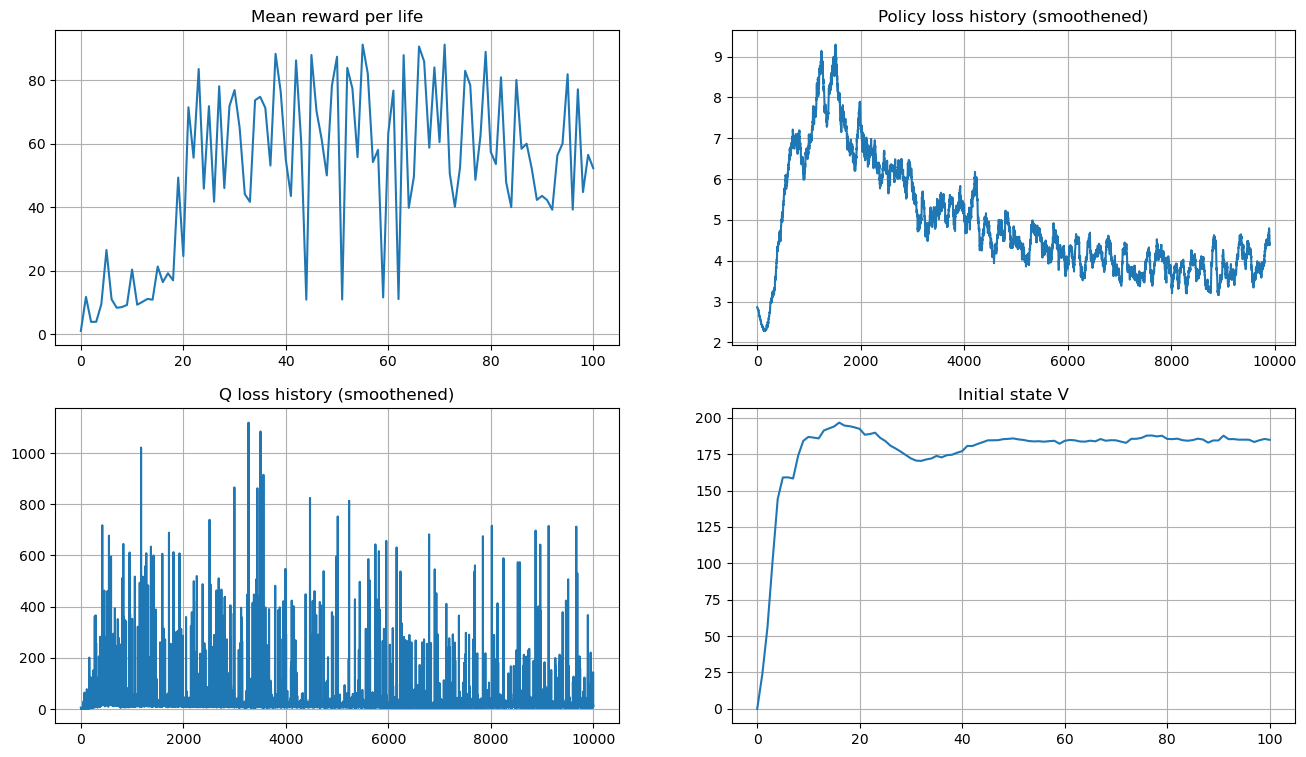

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500001/500001 [1:05:12<00:00, 127.79it/s]


In [53]:
ENV_NAME = "hopper-medium-replay-v2"

iql, mean_rw, q_loss, policy_loss, initial_state_v = train_awac_on_env(ENV_NAME, device, eval_games=10, beta=1.0)

In [55]:
awac = iql # Случайно не так назвал переменную
env = gym.make(ENV_NAME)
r = evaluate(env, device, awac.policy, seed=12, n_games=100)
print("Average reward after 5e5 iterations: ", env.get_normalized_score(r) * 100)

Average reward after 5e5 iterations:  53.159941981381145


**AWAC** на hopper-medium-replay-v2 c параметром **beta = 3.0** (действуем свободнее, в попытке максимизировать награды)

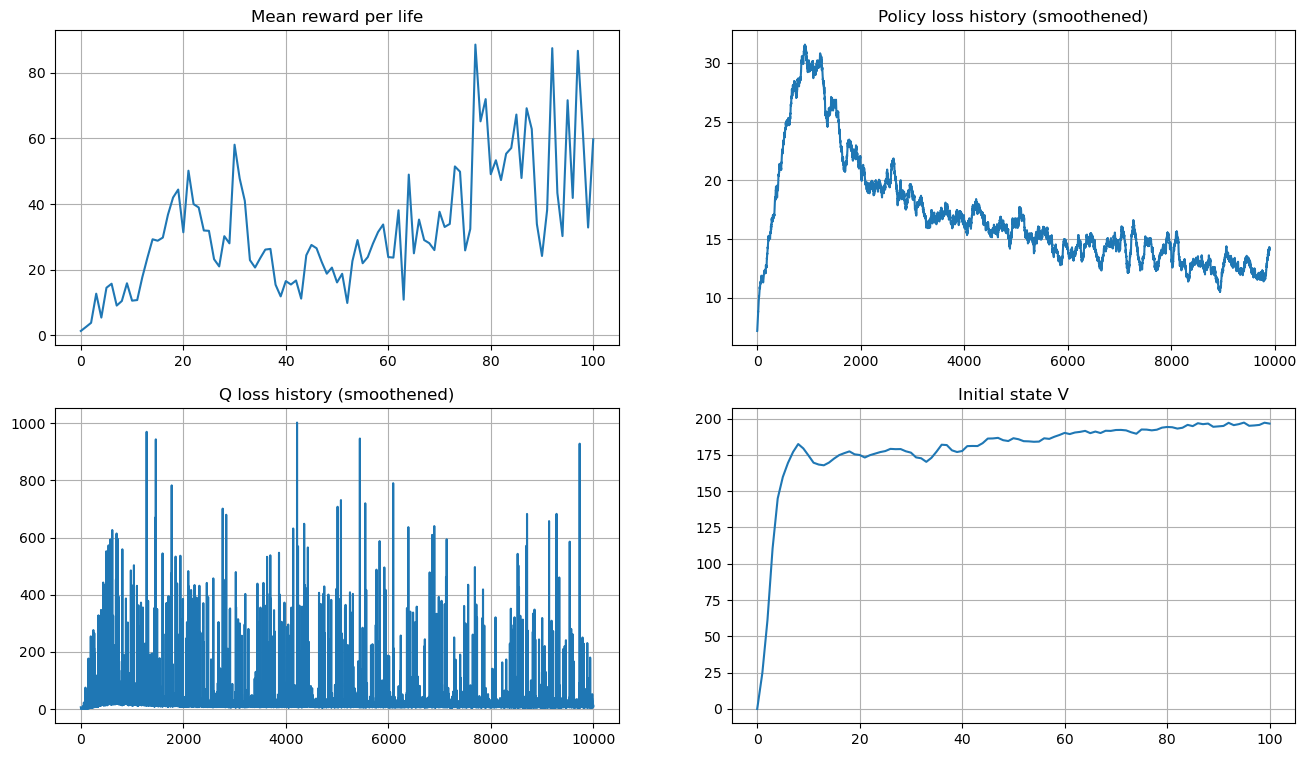

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500001/500001 [1:03:33<00:00, 131.12it/s]


In [44]:
ENV_NAME = "hopper-medium-replay-v2"

iql, mean_rw, q_loss, policy_loss, initial_state_v = train_awac_on_env(ENV_NAME, device, eval_games=10, beta=3.0)

In [52]:
awac = iql # Случайно не так назвал переменную
env = gym.make(ENV_NAME)
r = evaluate(env, device, awac.policy, seed=12, n_games=100)
print("Average reward after 5e5 iterations: ", env.get_normalized_score(r) * 100)

Average reward after 5e5 iterations:  59.21156624164071


### Implicit Q-learning: основные параметры - beta и tau. tau - коэффициент экспектильной регрессии: чем больше значение, тем больший экспектиль распределения мы пытаемся аппроксимировать, а соответственно сильнее максимизируем награду.

**IQL** на hopper-medium-replay-v2 c **"дефолтными"** параметрами (**beta = 3.0**, **tau=0.7**)

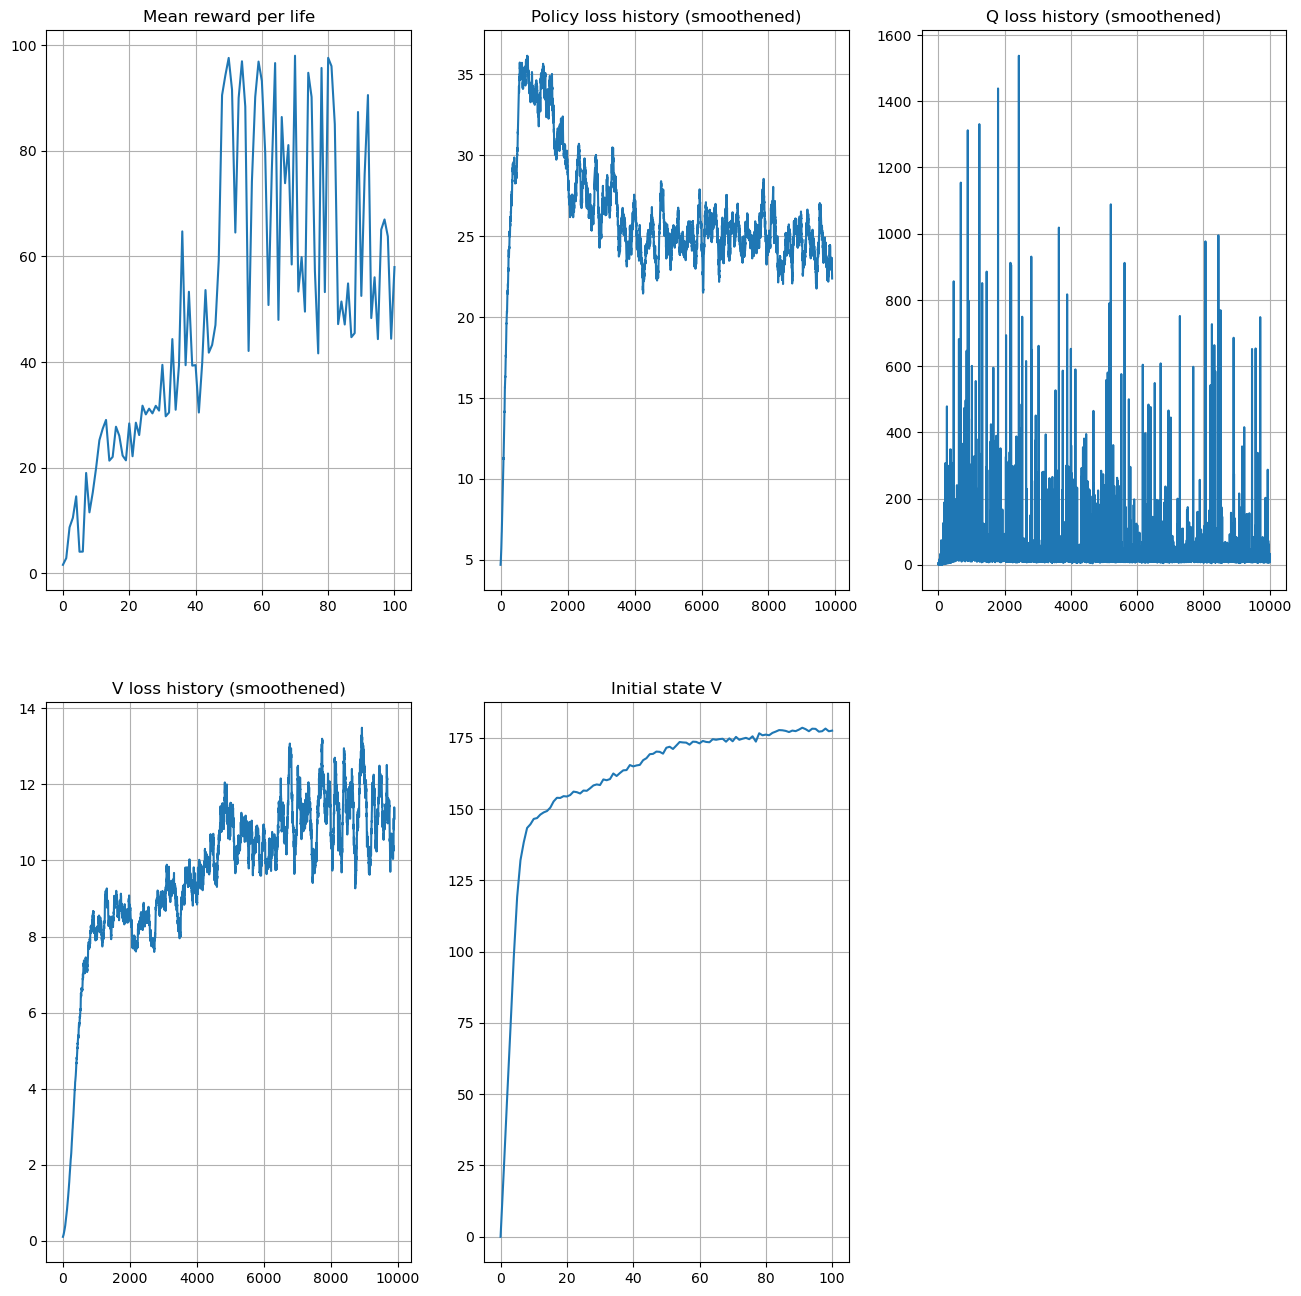

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500001/500001 [1:06:47<00:00, 124.76it/s]


In [60]:
ENV_NAME = "hopper-medium-replay-v2"

iql, mean_rw, q_loss, v_loss, policy_loss, initial_state_v = train_iql_on_env(ENV_NAME, device, eval_games=10, 
                                                                              tau=0.7, beta=3.0)

In [61]:
env = gym.make(ENV_NAME)
r = evaluate(env, device, iql.policy, seed=12, n_games=100)
print("Average reward after 5e5 iterations: ", env.get_normalized_score(r) * 100)

Average reward after 5e5 iterations:  56.04606857040526


**IQL** на hopper-medium-replay-v2 c параметрами **beta = 3.0**, **tau=0.9** (попытка сильнее максимизировать награды используя более строгий экспектиль)

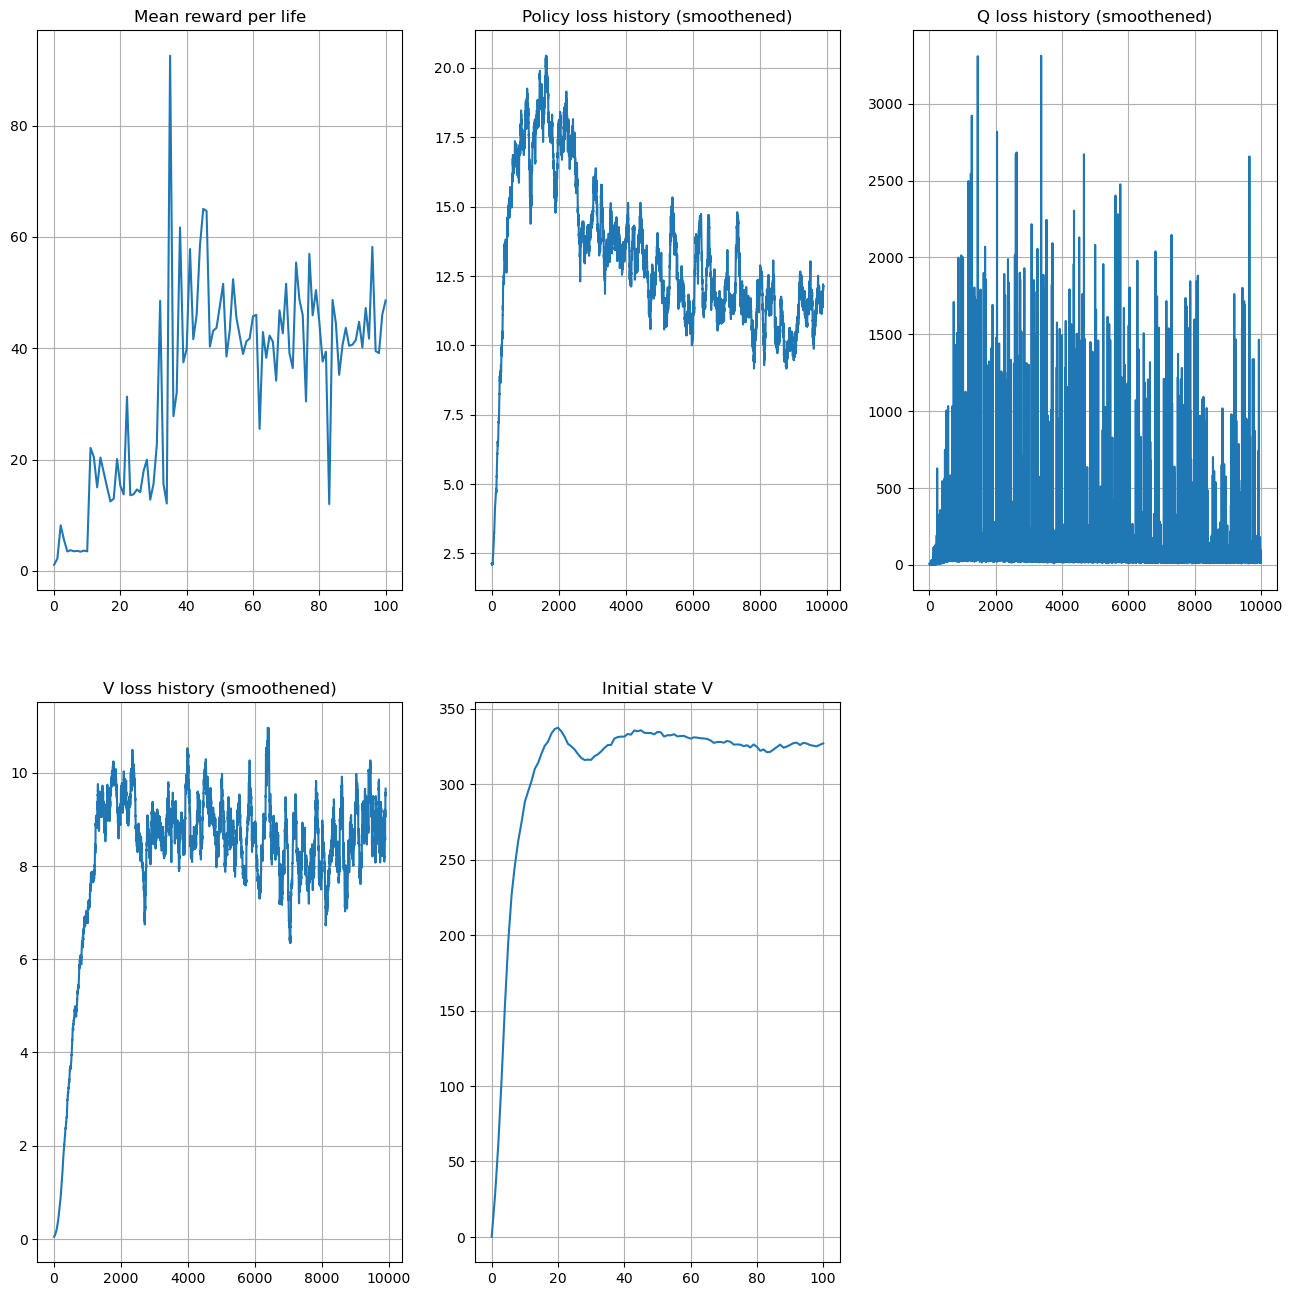

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500001/500001 [1:06:15<00:00, 125.77it/s]


In [63]:
ENV_NAME = "hopper-medium-replay-v2"

iql, mean_rw, q_loss, v_loss, policy_loss, initial_state_v = train_iql_on_env(ENV_NAME, device, eval_games=10, 
                                                                              tau=0.9, beta=3.0)

In [64]:
env = gym.make(ENV_NAME)
r = evaluate(env, device, iql.policy, seed=12, n_games=100)
print("Average reward after 5e5 iterations: ", env.get_normalized_score(r) * 100)

Average reward after 5e5 iterations:  47.62554265090982


**IQL** на hopper-medium-replay-v2 c параметрами **beta = 3.0**, **tau=0.6** (более слабый экспектиль)

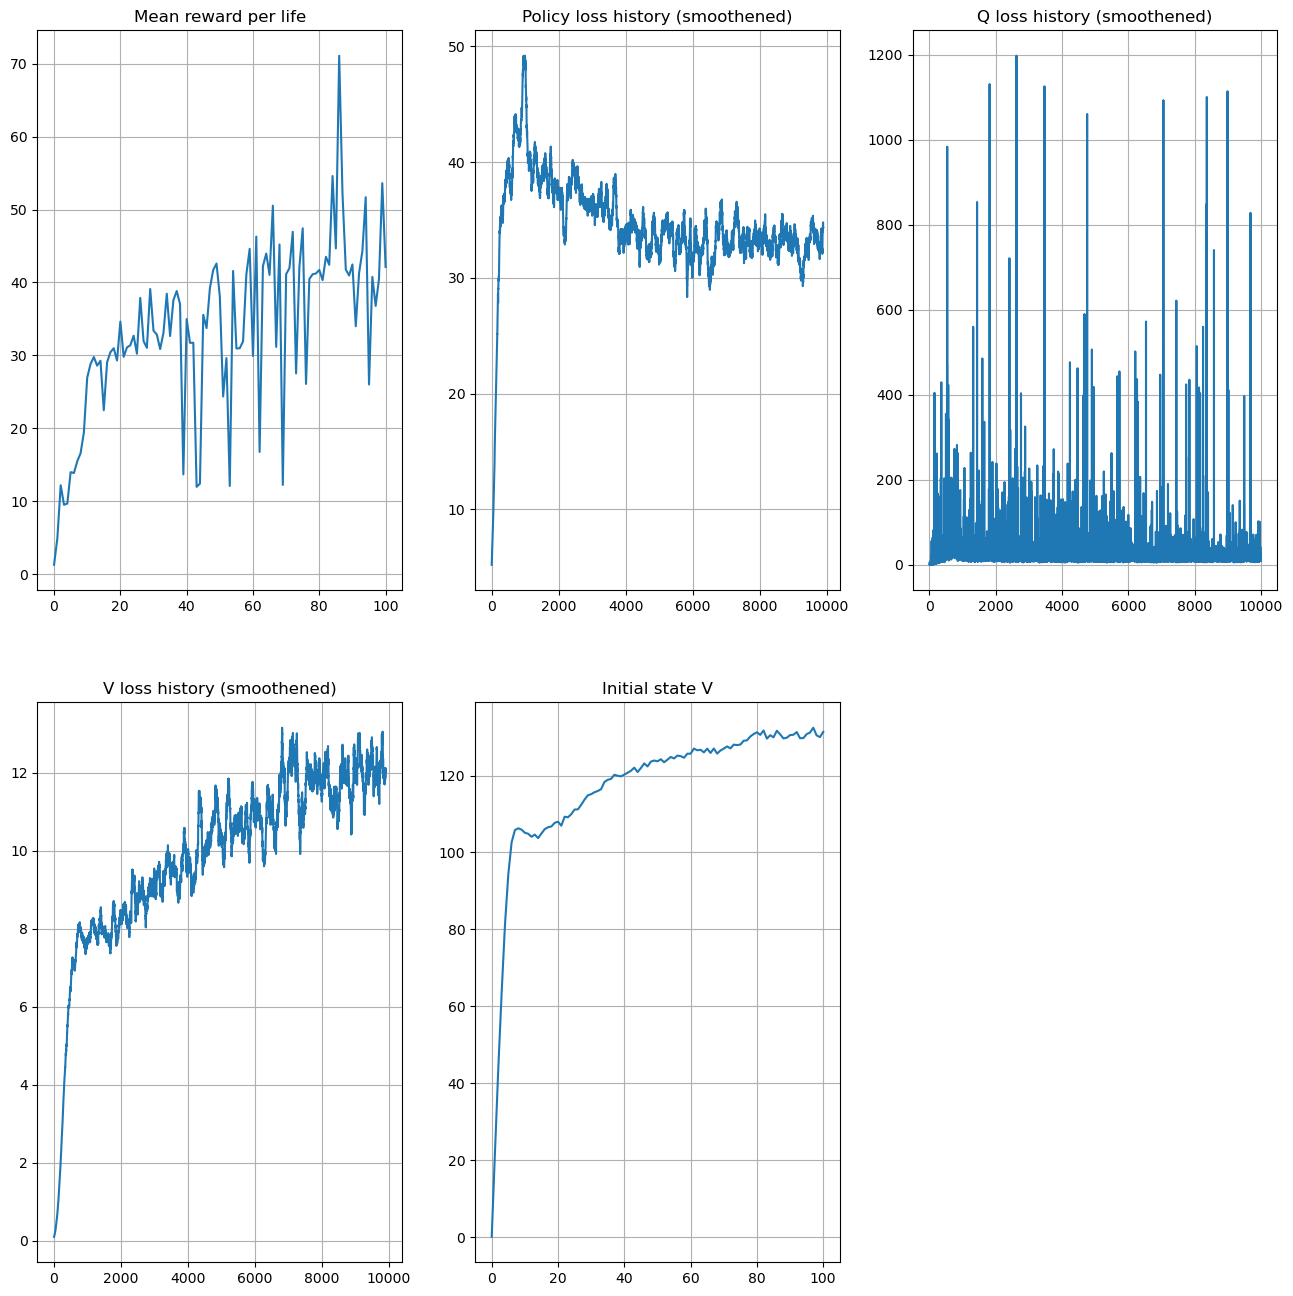

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500001/500001 [1:05:56<00:00, 126.37it/s]


In [66]:
ENV_NAME = "hopper-medium-replay-v2"

iql, mean_rw, q_loss, v_loss, policy_loss, initial_state_v = train_iql_on_env(ENV_NAME, device, eval_games=10, 
                                                                              tau=0.6, beta=3.0)

In [67]:
env = gym.make(ENV_NAME)
r = evaluate(env, device, iql.policy, seed=12, n_games=100)
print("Average reward after 5e5 iterations: ", env.get_normalized_score(r) * 100)

Average reward after 5e5 iterations:  42.33342988723009
